# NEW YORK airbnb flats

In [1]:
import osmnx as ox
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ox.__version__

'1.3.0'

#### Загружаем граф географической области

In [4]:
G = ox.graph_from_place('New York, USA', network_type='drive')

In [6]:
G2 = ox.graph_from_place('Moscow, Russia', network_type='drive')

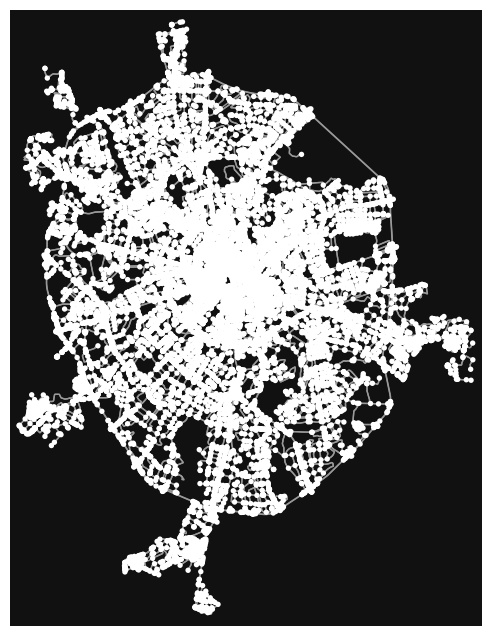

In [7]:
fig, ax = ox.plot_graph(G2)

#### Загружаем датасет

In [5]:
data = pd.read_csv('AB_NYC_2019.csv')
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


#### Анализ данных

In [6]:
# типы недвижимости, которую можно арендовать
data['room_type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

In [7]:
# районы NY
data['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

Text(0.5, 0, 'Data')

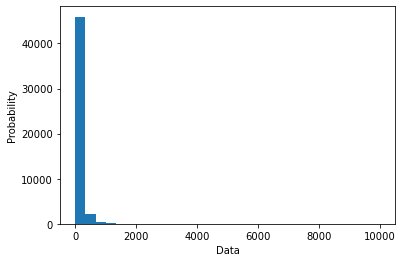

In [8]:
# посмотрим на распределение стоимости аренды
prices = data['price'].values
plt.hist(prices, bins=30)
plt.ylabel('Probability')
plt.xlabel('Data')

In [9]:
# квантиль 0.99 от цены
data['price'].quantile(.99)

799.0

In [10]:
# избавимся от ценовых выбросов
data = data[data['price']<data['price'].quantile(.99)]

Text(0.5, 0, 'Data')

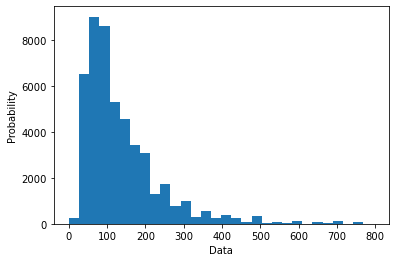

In [11]:
# посмотрим на распределение еще раз стоимости аренды
prices = data['price'].values
plt.hist(prices, bins=30)
plt.ylabel('Probability')
plt.xlabel('Data')

In [12]:
# средняя цена объекта недвижимости
data['price'].mean()

137.29793607834225

In [13]:
# квантиль 0.2 от цены
data['price'].quantile(.2)

60.0

In [14]:
# оставим только дешевые варианты
data = data[data['price']<data['price'].quantile(.2)]

In [15]:
len(data)

8605

In [16]:
# аренда нужна на 1-2 дня
data = data[data['minimum_nights']<3]

In [17]:
len(data)

4627

In [18]:
# хорошо бы, чтобы объект был достаточно популярный
data['number_of_reviews'].mean()

30.18781067646423

In [19]:
data = data[data['number_of_reviews']>data['number_of_reviews'].mean()]

In [20]:
len(data)

1270

In [21]:
# исключаем апартаменты и общие комнаты
data = data[data['room_type'] == 'Private room']

In [22]:
# доступна в большинство календарных дней
data = data[data['availability_365'] > 300]

In [23]:
# район Manhattan
data = data[data['neighbourhood_group'] == 'Manhattan']

In [24]:
len(data)

18

#### Найдем объект ближайший по расположению к Empire State Building

In [25]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://bashni.info/wp-content/uploads/2018/05/Sunset-at-the-Empire-State.jpg")

In [26]:
latitude = data['latitude'].values
longitude = data['longitude'].values

In [27]:
latitude

array([40.83403, 40.82264, 40.82124, 40.85933, 40.80759, 40.80732,
       40.80617, 40.79637, 40.82153, 40.80749, 40.87157, 40.85256,
       40.87133, 40.83018, 40.80039, 40.80715, 40.81609, 40.8068 ])

In [28]:
# Координаты ESB
latitude_ESB = 40.748391
longtitude_ESB = -73.985543

/opt/conda/lib/python3.8/site-packages/osmnx/plot.py:55: UserWarning: The fig_height, fig_width parameter(s) have been deprecated and will be removed in the next release. Note, fig_height and fig_width are replaced by the figsize parameter, use that instead. 
  warnings.warn(msg)


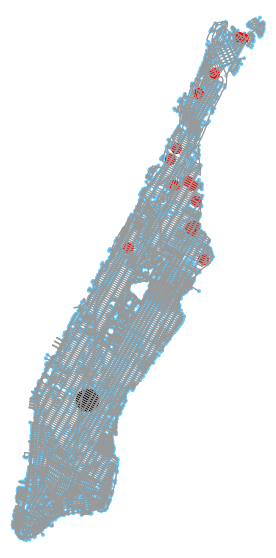

In [29]:
# Посмотрит на объекты на карте

fig, ax = ox.plot_graph(
                        G, fig_height=10, fig_width=10, 
                        show=False, close=False
                        )

ax.scatter(longitude,latitude,  c='red', s=100)#, alpha=0.3)
ax.scatter(longtitude_ESB,latitude_ESB,  c='black', s=500)#, alpha=0.3)

plt.show()

In [30]:
# Найдем вершину графа G, ближайшую к ESB

ESB_point = latitude_ESB, longtitude_ESB
nearest_edge_ESB = ox.get_nearest_edge(G, ESB_point)

In [31]:
nearest_edge_ESB

(42446701, 6224277863, 0)

In [32]:
# Найдем вершины графа G, ближайшие к объектам

nearest_edges = ox.get_nearest_edges(G, longitude, latitude)

In [33]:
# Всего вершин

len(list(G))

18447

#### Нарисуем один путь

In [34]:
route = nx.shortest_path(G, nearest_edge_ESB[0], nearest_edges[0][0])

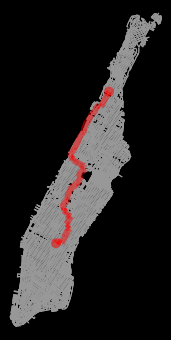

In [35]:
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

#### Измерим один путь

In [36]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [37]:
route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))
route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')))

In [38]:
print('Route  is', route_length, 'meters and takes', route_time, 'seconds.')

Route  is 13031 meters and takes 1170 seconds.


#### Теперь измерим по всем объектам

In [39]:
route_lengths = []
route_times = []
for i in range(len(latitude)):
    route = nx.shortest_path(G, nearest_edge_ESB[0], nearest_edges[i][0])
    route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))
    route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')))
    route_lengths.append(route_length)
    route_times.append(route_time)

    print('Route  is', route_length, 'meters and takes', route_time, 'seconds.')

Route  is 13031 meters and takes 1170 seconds.
Route  is 13230 meters and takes 1189 seconds.
Route  is 12833 meters and takes 1154 seconds.
Route  is 17785 meters and takes 1600 seconds.
Route  is 10696 meters and takes 958 seconds.
Route  is 10775 meters and takes 965 seconds.
Route  is 10537 meters and takes 943 seconds.
Route  is 10792 meters and takes 966 seconds.
Route  is 12249 meters and takes 1100 seconds.
Route  is 10696 meters and takes 958 seconds.
Route  is 19887 meters and takes 1790 seconds.
Route  is 15630 meters and takes 1408 seconds.
Route  is 20271 meters and takes 1825 seconds.
Route  is 12596 meters and takes 1131 seconds.
Route  is 8849 meters and takes 791 seconds.
Route  is 10696 meters and takes 958 seconds.
Route  is 11173 meters and takes 1002 seconds.
Route  is 10617 meters and takes 951 seconds.


In [40]:
np.argmin(route_times)

14

In [41]:
my_choice = data.iloc[np.argmin(route_times)]
print(my_choice)

id                                                                       15246070
name                              Lovely&Morden bedroom near everything you want!
host_id                                                                  33064599
host_name                                                                   Yukee
neighbourhood_group                                                     Manhattan
neighbourhood                                                     Upper West Side
latitude                                                                  40.8004
longitude                                                                -73.9672
room_type                                                            Private room
price                                                                          49
minimum_nights                                                                  1
number_of_reviews                                                              56
last_review     

In [42]:
print(my_choice['latitude'], my_choice['longitude'])

40.80039 -73.96724


/opt/conda/lib/python3.8/site-packages/osmnx/plot.py:55: UserWarning: The fig_height, fig_width parameter(s) have been deprecated and will be removed in the next release. Note, fig_height and fig_width are replaced by the figsize parameter, use that instead. 
  warnings.warn(msg)


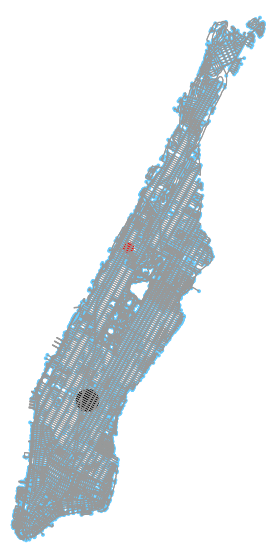

In [43]:
fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, 
                        show=False, close=False
                        )

ax.scatter(my_choice['longitude'],my_choice['latitude'],  c='red', s=100)
ax.scatter(longtitude_ESB,latitude_ESB,  c='black', s=500)

plt.show()